# Machine Translation with Attention

In the [previous example](./07_encoder_decoder.ipynb), we saw sequence-to-sequence encoder-decoder architecture in machine translation.<br>
In the previous example, the input sequence is encoded into a single context, and this context is used for decoding in all units in generated sequence.

This architecture will not be flexible, and also not scalable. For instance, in case of machine translation, it will be difficult to translate a long text (such as, translate multiple sentences at once) unlike human translation. (Because a single context will not be enough to represent entire text, when the text becomes larger.)

By introducing attention architecture, this constraint can be relaxed.<br>
The attention is more elaborative and widely used architecture in today's NLP, and a lot of tasks (such as, machine translation, smart reply, etc) are researched by adding attention mechanism and worked well today.

In the overview outline of attention architecture, the different context can be used in each units in sequence for decoding as follows.

![encoder-decoder with attention architecture](./images/encoder_decoder_attention.png)

Within attention, first it will generate $\{ \alpha_j^i \}\;(i=1,\ldots,n)$, in which $\sum_i \alpha_j^i = 1$, with dense net (FCNet) and softmax activation, where $n$ is the number of encoder's outputs and $j$ is time step in sequence. (See the following diagram.)<br>
To say in abstraction, $\{ \alpha_j^i \}\;(i=1,\ldots,n)$ means an alignment's weight at j-th time step for each source sequence outputs, $o_1^{\prime}, o_2^{\prime}, \ldots, o_n^{\prime}$.<br>
(This $\{ \alpha_j^i \}\;(i=1,\ldots,n)$ is then called attention weights.)

> Note : See [here](https://tsmatz.wordpress.com/2017/08/30/glm-regression-logistic-poisson-gaussian-gamma-tutorial-with-r/) for softmax function. (It's used for normalizing outputs (sum to one).)

And it then generates context $c_j$ at j-th time step by $ c_j = \sum_i^n \alpha_j^i \cdot o_i^{\prime} $.

![soft attention architecture](./images/soft_attention.png)

> Note : This architecture is called *soft attention*, which is the first attention introduced in the context of sequence-to-sequence generation. (See Bahdanau et al.)<br>
> There exist a lot of variants in attention architecture. See [this post](https://tsmatz.wordpress.com/2021/11/11/reinforcement-learning-visual-attention-in-minecraft/) for self-attention architecture (**transformer**), which is widely used SOTA architecture in a lot of today's NLP tasks.

With this network, it can focus on specific components in source sequence.<br>
For instance, in case of the following French-to-English machine translation, the 3rd units in sequence ("don't" in English) will focus on 3rd and 5th components in original sequence, because the word "don't" will strongly focus on the source French "ne" and "pas". But others ("je" or "comprends") are also weakly referred, because it's used for determining not "doesn't" or not "isn't".<br>
As a result, the attention weights $\{ \alpha_j^i \}\;(i=1,\ldots,n)$ will be large for the source components "ne" and "pas", and will be small for the source components "je" and "comprends".

![attend in machine translation](./images/attend_image.png)

*back to [index](https://github.com/tsmatz/nlp-tutorials/)*

## Install required packages

In [ ]:
!pip install tensorflow==2.6.2 numpy nltk matplotlib

## Prepare data

In this example, I use Engligh-French dataset by [Anki](https://www.manythings.org/anki/).

In [1]:
!wget http://www.manythings.org/anki/fra-eng.zip

--2022-09-06 19:13:30--  http://www.manythings.org/anki/fra-eng.zip
Resolving www.manythings.org (www.manythings.org)... 173.254.30.110
Connecting to www.manythings.org (www.manythings.org)|173.254.30.110|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6720195 (6.4M) [application/zip]
Saving to: ‘fra-eng.zip’

fra-eng.zip         100%[===================>]   6.41M  7.52MB/s    in 0.9s    

2022-09-06 19:13:31 (7.52 MB/s) - ‘fra-eng.zip’ saved [6720195/6720195]



In [2]:
!unzip fra-eng.zip -d fra-eng

Archive:  fra-eng.zip
  inflating: fra-eng/_about.txt      
  inflating: fra-eng/fra.txt         


In [3]:
!head -n 5 fra-eng/fra.txt

Go.	Va !	CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #1158250 (Wittydev)
Go.	Marche.	CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #8090732 (Micsmithel)
Go.	En route !	CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #8267435 (felix63)
Go.	Bouge !	CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #9022935 (Micsmithel)
Hi.	Salut !	CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #509819 (Aiji)


In [4]:
!wc -l fra-eng/fra.txt

197463 fra-eng/fra.txt


In [5]:
from pathlib import Path
import numpy as np

pathobj = Path("fra-eng/fra.txt")
text_all = pathobj.read_text(encoding="utf-8")
lines = text_all.splitlines()
train_data = [line.split("\t") for line in lines]
train_data = np.array(train_data)[:,[1,0]]
# print first row
train_data[0]

array(['Va !', 'Go.'], dtype='<U349')

In this training set, text length in the latter part is longer (and includes multiple sentences) than the former part.<br>
Therefore I shuffle entire data.

In [6]:
np.random.shuffle(train_data)
train_data[0]

array(['Quoi que vous fassiez, ne tirez pas sur cette corde !',
       "Whatever you do, don't pull this rope."], dtype='<U349')

When data consists of multiple sentences, it converts to a single sentence.

In [7]:
import nltk
import nltk.data

nltk.download("punkt")
tokenizer_en = nltk.data.load("tokenizers/punkt/english.pickle")
tokenizer_fr = nltk.data.load("tokenizers/punkt/french.pickle")
fr_list = []
en_list = []
for x in train_data:
    x1 = tokenizer_fr.tokenize(x[0])
    x2 = tokenizer_en.tokenize(x[1])
    if len(x1) == len(x2):
        fr_list += x1
        en_list += x2
train_data = np.column_stack((fr_list, en_list))

[nltk_data] Downloading package punkt to /home/tsmatsuz/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


To get the better performance (accuracy), I standarize the input text as follows.
- Make all words to lowercase in order to reduce words
- Make "-" (hyphen) to space
- Remove all punctuation except " ' " (e.g, Ken's bag, ces't, ...)

> Note : To make simplify, I have skipped other pre-processing, such as, N-gram detection (see [this exercise](./05_ngram_cnn.ipynb)), polysemy processing, etc.

In [8]:
import string

train_data = np.char.lower(train_data)
train_data = np.char.replace(train_data, "-", " ")
for x in string.punctuation.replace("'", ""):
    train_data = np.char.replace(train_data, x, "")
for x in "«»":
    train_data = np.char.replace(train_data, x, "")
train_data = np.char.strip(train_data)
# print first row
train_data[0]

array(['quoi que vous fassiez ne tirez pas sur cette corde',
       "whatever you do don't pull this rope"], dtype='<U250')

Add ```[START]``` and ```[END]``` tokens in string.

In [9]:
train_data = np.array([[" ".join(["[START]", x, "[END]"]), " ".join(["[START]", y, "[END]"])] for x, y in train_data])
# print first row
train_data[0]

array(['[START] quoi que vous fassiez ne tirez pas sur cette corde [END]',
       "[START] whatever you do don't pull this rope [END]"],
      dtype='<U264')

## Generate sequence inputs

We will generate the sequence of word's indices (i.e, tokenize) from text.

![Index vectorize](images/index_vectorize2.png?raw=true)

First, we build word's vectorizer for both source text (French) and target text (English).

In [10]:
import tensorflow as tf

max_word = 10000

source_vectorization = tf.keras.layers.TextVectorization(
    max_tokens=max_word,
    output_sequence_length=None, # maximum length of sequences
    output_mode="int")
source_vectorization.adapt(train_data[:,0])

target_vectorization = tf.keras.layers.TextVectorization(
    max_tokens=max_word,
    output_sequence_length=None, # maximum length of sequences
    output_mode="int")
target_vectorization.adapt(train_data[:,1])

Now we vectorize sentence into integer's sequence as follows.<br>
In this example, we create fixed size of sequence (padded by 0) in each row.

![Index vectorize](images/index_vectorize2.png?raw=true)

In [11]:
train_source = source_vectorization(train_data[:,0])
train_target = target_vectorization(train_data[:,1])
# print first row
print(train_source[0])
print(train_target[0])

tf.Tensor(
[   3  117    8    7 1674   10 4527    6   63   54 1426    2    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0], shape=(45,), dtype=int64)
tf.Tensor(
[   2  759    5   12   19 1428   16 1295    3    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0], shape=(38,), dtype=int64)


Make TensorFlow dataset.

In [12]:
train_tf_data = tf.data.Dataset.from_tensor_slices((train_source, train_target))

Now we generate label (y) for training.

As I have mentioned above, we should finally predict the next word in target sentence (English) using current word and encoded context.<br>
We then create the following label (y) in each row.

<u>input - list of current words</u> :
```
[2, 7, 5, 3, 0, ... , 0]
```

<u>output (y) - list of next words</u> :
```
[7, 5, 3, 0, 0, ... , 0]
```

In [13]:
def add_label(x_source, x_target):
    y = tf.slice(x_target, begin=[1], size=[len(x_target) - 1])
    y = tf.concat([y, [0]], axis=0)
    return (x_source, x_target), y
train_tf_data = train_tf_data.map(lambda src, tar: add_label(src, tar))
# print first row
for x, y in train_tf_data.take(1):
    print("***** X *****")
    print(x)
    print("***** y *****")
    print(y)

***** X *****
(<tf.Tensor: shape=(45,), dtype=int64, numpy=
array([   3,  117,    8,    7, 1674,   10, 4527,    6,   63,   54, 1426,
          2,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0])>, <tf.Tensor: shape=(38,), dtype=int64, numpy=
array([   2,  759,    5,   12,   19, 1428,   16, 1295,    3,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0])>)
***** y *****
tf.Tensor(
[ 759    5   12   19 1428   16 1295    3    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0], shape=(38,), dtype=int64)


Now we convert label y into one-hot vector (shape (max_word,)).

y (before) :
```
[4, 1, 3, 0]
```

y (after) :
```
[
  [0,0,0,0,1, ... ,0],
  [0,1,0,0,0, ... ,0],
  [0,0,0,1,0, ... ,0],
  [1,0,0,0,0, ... ,0]
]
```

In [14]:
def to_one_hot(x, y):
    y_new = tf.one_hot(y, depth=max_word)
    return x, y_new
train_tf_data = train_tf_data.map(lambda x, y: to_one_hot(x, y))
# print y in first row
for x, y in train_tf_data.take(1):
    print(y)

tf.Tensor(
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]], shape=(38, 10000), dtype=float32)


## Train with Encoder-Decoder

Now we build an attention model in encoder-decoder architecture as follows.

- Outputs in RNN (for source text) are generated in encoder.
- Encoder's outputs are used in attention architecture and passed into each unit in decoder's RNN.
- Each RNN output in decoder is passed into dense (FCNet) layer and generate the sequence of next words.
- Calculate loss between predicted next words and the true values of next words, and then proceed to train.

![the trainer architecture of machine translation](./images/machine_translation2.png)

First, we build encoder model.

In the following ```tf.keras.layers.GRU``` layer, the shape of RNN input is expected to be ```(batch_size, sequence_length, input_dimension)```. By setting ```stateful=True```, the last state at index i in batch is used as initial state for index i in the following batch.<br>
Here we then set ```stateful=False```. (Because the sequence in the following batch doesn't depend on the sequence in previous batch.)

Unlike [previous example](./07_encoder_decoder.ipynb), all outputs in sequence is used in the next model, and it should then return all outputs (not only the last output).<br>
Therefore I set ```return_sequences=True``` in RNN (GRU layer).

![all outputs in encoder](./images/encoder_all.png)

Remind that the length of each sequence differs in each row and it's padded by zero.<br>
Therefore, here I create mask, in which, the element is TRUE when it exists and FALSE when it's missing.<br>
By passing mask into RNN, the computation will be skipped in FALSE elements.

> Note : You can also set encoder's final state as decoder's initial state.<br>
> In this example, I'll discard encoder's final state in the model.

In [15]:
class Encoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, rnn_units):
        super().__init__(self)
        self.vocab_size = vocab_size

        self.embedding = tf.keras.layers.Embedding(
            self.vocab_size,
            embedding_dim,
            mask_zero=True,
            trainable=True,
        )
        self.rnn = tf.keras.layers.GRU(
            rnn_units,
            use_bias=True,
            return_sequences=True,  # see above !
            return_state=True,
            stateful=False,  # not to inherit states between batches
            trainable=True,
        )

    def call(self, inputs, states=None, training=False, return_state=False):
        inputs_emb = self.embedding(inputs, training=training)
        mask = self.embedding.compute_mask(inputs)
        if states is None:
            outputs, new_states = self.rnn(inputs_emb, mask=mask, training=training)
        else:
            outputs, new_states = self.rnn(inputs_emb, mask=mask, initial_state=states, training=training)
        if return_state:
            return outputs, new_states  # This is used in prediction
        else:
            return outputs              # This is used in training

Now we build decoder with attention architecture as follows. (The following variable ```alpha``` is attention weights at ```j```-th step.)

As I have mentioned above, decoder receives encoder's outputs (outputs for all components in sequence), and this is commonly used in all steps in target sequence.

In each steps in target RNN sequence, the state in previous step is used in attention layer. For the purpose of your learning, here I manually implement this loop of RNN steps from scratch as follows. (See the following ```for``` loop in attention process.)<br>
However, you can use your custom RNN cell (one step cell in RNN) or use ```tfa.seq2seq.AttentionWrapper``` with ```tf.keras.layers.GRUCell``` to build this kind of RNN steps with attention in TensorFlow.

The softmax operation should be masked in attention layer.

![decoder with attention](./images/decoder_attention.png)

In [16]:
class DecoderWithAttention(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, rnn_units):
        super().__init__(self)
        self.vocab_size = vocab_size

        self.embedding = tf.keras.layers.Embedding(
            self.vocab_size,
            embedding_dim,
            mask_zero=True,
            trainable=True,
        )
        self.attention_dense1 = tf.keras.layers.Dense(
            rnn_units,
            activation="relu",
        )
        self.attention_dense2 = tf.keras.layers.Dense(
            1,
            activation=None,
        )
        self.softmax = tf.keras.layers.Softmax(
            axis=-1
        )
        self.rnn = tf.keras.layers.GRU(
            rnn_units,
            use_bias=True,
            return_sequences=False,
            return_state=True,
            stateful=False,  # not to inherit states between batches
            trainable=True,
        )
        self.output_dense1 = tf.keras.layers.Dense(
            rnn_units,
            activation="relu",
        )
        self.output_dense2 = tf.keras.layers.Dense(
            self.vocab_size,
            activation=None,
        )

    def call(self, inputs, states=None, training=False, return_state=False):
        inputs_target, enc_outputs = inputs

        #
        # get batch size and sequence size
        #
        batch_size = tf.shape(inputs_target)[0]
        dec_sequence_size = tf.shape(inputs_target)[1]
        enc_sequence_size = tf.shape(enc_outputs)[1]
        mask = self.embedding.compute_mask(inputs_target)

        #
        # process embedding
        #
        inputs_emb = self.embedding(inputs_target, training=training) # shape: (batch_size, dec_sequence_size, embedding_dim)

        #
        # process attention
        # (You can also use built-in tf.keras.layers.AdditiveAttention.)
        #

        # set initial state
        if states is None:
            current_states = tf.zeros([batch_size, rnn_units]) # you can also use self.rnn.get_initial_state(...)
        else:
            current_states = states
        # loop sequence
        rnn_outputs = []
        for j in range(dec_sequence_size):
            states_fill_sequence = tf.expand_dims(current_states, axis=1) # shape : (batch_size, 1, rnn_units)
            states_fill_sequence = tf.tile(states_fill_sequence, multiples=[1,enc_sequence_size,1]) # shape : (batch_size, enc_sequence_size, rnn_units)
            enc_and_states = tf.concat([states_fill_sequence, enc_outputs], axis=-1) # shape : (batch_size, enc_sequence_size, rnn_units * 2)
            alpha = self.attention_dense1(enc_and_states, training=training) # shape : (batch_size, enc_sequence_size, rnn_units)
            alpha = self.attention_dense2(alpha, training=training) # shape : (batch_size, enc_sequence_size, 1)
            alpha = tf.squeeze(alpha, axis=2) # shape : (batch_size, enc_sequence_size)
            ### use masking !
            # alpha = tf.nn.softmax(alpha, axis=-1) # shape: (batch_size, enc_sequence_size)
            attention_mask = enc_outputs._keras_mask
            attention_mask = tf.cast(attention_mask, tf.float32) # True -> 1.0, False -> 0.0
            alpha = self.softmax(alpha, attention_mask) # shape: (batch_size, enc_sequence_size)
            c = tf.einsum("bs,bsu->bu", alpha, enc_outputs) # shape: (batch_size, rnn_units)
            emb_j = inputs_emb[:,j,:] # shape: (batch_size, embedding_dim)
            input_j = tf.concat([c, emb_j], axis=-1) # shape: (batch_size, rnn_units + embedding_dim)
            input_j = tf.expand_dims(input_j, axis=1) # shape: (batch_size, 1, rnn_units + embedding_dim)
            mask_j = tf.expand_dims(mask[:,j], axis=1)
            rnn_o, current_states = self.rnn(input_j, mask=mask_j, initial_state=current_states, training=training) # shape: (batch_size, rnn_units)
            rnn_outputs.append(rnn_o)
        rnn_outputs = tf.stack(rnn_outputs, axis=1) # shape: (batch_size, dec_sequence_size, rnn_units)

        #
        # process vocab outputs
        #
        outputs = self.output_dense1(rnn_outputs, training=training)
        outputs = self.output_dense2(outputs, training=training)

        if return_state:
            return outputs, mask, current_states  # This is used in prediction
        else:
            return outputs, mask                  # This is used in training

Now we put it all together and run training.

I note that the loss computation is also masked. (i.e, The loss is ignored in missing elements.)

> Note : In the following example, I'm writing a training loop from scratch, but you can also build TensorFlow custom model for this implementation.

In [17]:
embedding_dim = 256
rnn_units = 1024
n_epoch = 5
shuffle_buffer_size = 5000
train_batch_size = 64
loss_records = []

enc_model = Encoder(
    vocab_size=max_word,
    embedding_dim=embedding_dim,
    rnn_units=rnn_units)
dec_model = DecoderWithAttention(
    vocab_size=max_word,
    embedding_dim=embedding_dim,
    rnn_units=rnn_units)
loss_func = tf.keras.losses.CategoricalCrossentropy(
    from_logits=True,
    reduction=tf.keras.losses.Reduction.NONE
)
opt = tf.keras.optimizers.Adam(learning_rate=0.001)

### I don't use train_tf_data.repeat(n_epoch) and run shuffle in each epoch,
### because I want to check result in each epoch
for epoch in range(n_epoch):
    tf_data_epoch = train_tf_data.shuffle(shuffle_buffer_size).batch(train_batch_size)
    iterator = iter(tf_data_epoch)
    while True:
        with tf.GradientTape() as enc_tape, tf.GradientTape() as dec_tape:
            # get next batch
            try:
                input_batch_x, input_batch_y = iterator.get_next()
            except tf.errors.OutOfRangeError:
                loop_f = False
                break
            input_source, input_target = input_batch_x
            # process encoder
            enc_outputs = enc_model(
                input_source,
                training=True)
            # process decoder
            logits, mask = dec_model(
                (input_target , enc_outputs),
                training=True)
            # calculate masked loss
            loss = loss_func(
                input_batch_y,
                logits) # shape of loss is (batch_size, sequence_size)
            mask_float = tf.cast(mask, tf.float32) # True -> 1.0, False -> 0.0
            loss = loss * mask_float
            loss = tf.math.reduce_sum(loss, axis=1) # shape of loss is (batch_size, )
            loss = loss / tf.math.reduce_sum(mask_float, axis=1)
            # get gradient
            grad = enc_tape.gradient(
                loss,
                enc_model.trainable_variables+dec_model.trainable_variables
            )
        # apply gradient
        opt.apply_gradients(zip(grad, enc_model.trainable_variables+dec_model.trainable_variables))
        # record result
        batch_average_loss = tf.math.reduce_mean(loss).numpy().tolist()
        print("Epoch {}/{} - loss {loss:10.6f}".format(epoch+1, n_epoch, loss=batch_average_loss), end="\r")
        loss_records.append(batch_average_loss)
    # add line break
    print("")

Epoch 1/5 - loss   0.399578
Epoch 2/5 - loss   0.463912
Epoch 3/5 - loss   1.458908
Epoch 4/5 - loss   0.642533
Epoch 5/5 - loss   0.115093


After the training has completed, show how loss is optimized.

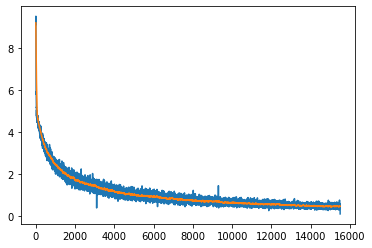

In [18]:
import numpy as np
import matplotlib.pyplot as plt

#loss_list = loss_records[:10000]
loss_list = loss_records

loss_average = []
for i in range(len(loss_list)):
    avg_list = np.empty(shape=(1,), dtype=int)
    if i < 50:
        avg_list = loss_list[:i+1]
    else:
        avg_list = loss_list[i-49:i+1]
    loss_average.append(np.average(avg_list))
plt.plot(loss_list)
plt.plot(loss_average)

## Translate Text

Now translate text (French) to English with trained model.<br>
(All these sentences are not in training set.)

In [19]:
import numpy as np

def translate(sentence):
    # preprocess french
    input_text_fr = sentence
    input_text_fr = input_text_fr.lower()
    input_text_fr = " ".join(["[START]", input_text_fr, "[END]"])

    text_seq_fr = source_vectorization(input_text_fr)
    text_seq_fr = tf.expand_dims(text_seq_fr, axis=0)

    # process encoder
    enc_outputs = enc_model(text_seq_fr)

    # process decoder
    vocab_list_en = target_vectorization.get_vocabulary()
    states = None
    prev_idx_en = target_vectorization("[START]")
    end_num_en = target_vectorization("[END]").numpy().tolist()[0]
    #text_seq_en = []
    #text_seq_en = tf.expand_dims(text_seq_en[len(text_seq_en) - 1], axis=0)
    while True:
        y, mask, states = dec_model(
            (tf.expand_dims(prev_idx_en, axis=0), enc_outputs),
            states=states,
            return_state=True)
        prev_idx_en = np.argmax(y[0])
        if prev_idx_en.item() == end_num_en:
            break
        print(vocab_list_en[prev_idx_en.item()], end=" ")
        prev_idx_en = tf.convert_to_tensor([prev_idx_en])
    print("\n")

In [20]:
translate("j'aime la guitare") # i like guitar
translate("il vit au japon") # he lives in Japan
translate("ce stylo est utilisé par lui") # this pen is used by him
translate("c'est ma chanson préférée") # that's my favorite song
translate("il conduit une voiture et va à new york") # he drives a car and goes to new york

i like the guitar 

he lives in japan 

this pen is used by him 

this is my favorite song 

he drives a car and goes to new york 

